### 그래프 환경설정

In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
sns.set()
%matplotlib inline
rcParams['font.family'] = 'Malgun Gothic'
rcParams['axes.unicode_minus'] = False

### 데이터 정제

In [2]:
import pandas as pd
data = pd.read_csv("../../데이터/주가리포트.txt", sep = "\t", encoding = "euc-kr")
display(data.head())

,종목명,리포트제목,적정가격,의견,증권사,날짜
0,SK하이닉스,리스크 관리가 좀더 필요한 시점,120000,매수(유지),하이투자증권,2021-10-15
1,솔루엠,수주잔고가 쌓인다,28000,매수(유지),하이투자증권,2021-10-15
2,유한양행,높아진 성공 가능성 할인보다 할증 요소,90000,매수(유지),키움증권,2021-10-15
3,코스모신소재,증설은 곧 성장이다,-,-,키움증권,2021-10-15
4,넷마블,"올해까지 실적으론 고평가, 내년 실적부턴 저평가",145000,매수,이베스트투자증권,2021-10-15


#### 의견 표현 통일

In [3]:
display(data['의견'].value_counts())

매수                      10396
매수(유지)                   4120
-                        1725
Hold                      227
OutPerform                144
중립                        141
MarketPerform              39
Neutral                    36
StrongBuy                  12
강력매수                       10
보유                          2
시장수익률                       2
신규매수                        2
적극매수                        1
단기매수                        1
매도                          1
Market Under Perform        1
Name: 의견, dtype: int64

In [4]:
data = data.loc[~data['의견'].isin(['매도', '-', 'Market Under Perform'])]

In [5]:
buy_opinions = ['매수(유지)', "Outperform", "StrongBuy", "강력매수", "신규매수", "단기매수", "적극매수"]
data.loc[data['의견'].isin(buy_opinions), '의견'] = "매수"
data.loc[data['의견'] != "매수", "의견"] = "중립"

In [6]:
display(data['의견'].value_counts(normalize = True))

매수    0.960946
중립    0.039054
Name: 의견, dtype: float64

#### 적정 숫자로 표현 

In [7]:
import numpy as np
def filtering_numeric(value):
    if type(value) == float:
        return value
    else:
        output = ''
        for s in value:
            if s.isnumeric():
                output += s
        if len(output) == 0:
            return np.nan
        else:
            return int(output)

In [8]:
print(filtering_numeric('12345'))
print(filtering_numeric('없음'))
print(filtering_numeric('12345원'))

12345
nan
12345


In [9]:
data['적정가격'] = data['적정가격'].apply(filtering_numeric)
data.dropna(inplace = True)

#### 주가 부착

In [10]:
import os
sp_data_dict = dict()
path = "../../데이터/주가데이터/"
for stock_name in data['종목명'].unique():
    if stock_name + ".csv" in os.listdir(path):
        sp_data = pd.read_csv(path + stock_name + ".csv", parse_dates = ['Date'])
        sp_data_dict[stock_name] = sp_data
    else:
        data = data.loc[data['종목명'] != stock_name]

In [11]:
def find_stock_price(stock_name, date, direction = "past"):    
    stock_data = sp_data_dict[stock_name]
    if (direction == "past") and (stock_data['Date'].min() > date):
        return np.nan    
    elif (direction == "future") and (stock_data['Date'].max() < date):
        return np.nan 
    else:
        while True:
            if sum(stock_data['Date'] == date) > 0: 
                value = stock_data.loc[stock_data['Date'] == date, 'Close'].iloc[0]  
                break
            else:
                if direction == "past":
                    date -= pd.to_timedelta(1, 'D')
                else:
                    date += pd.to_timedelta(1, 'D')
        return value

In [12]:
data["날짜"] = pd.to_datetime(data["날짜"])
sp_col = []
for idx, row in data.iterrows():
    value = find_stock_price(row["종목명"], row["날짜"], direction = "past")
    sp_col.append(value)
data["주가"] = sp_col

### 적정 가격과 주가 차이 탐색

<AxesSubplot:>

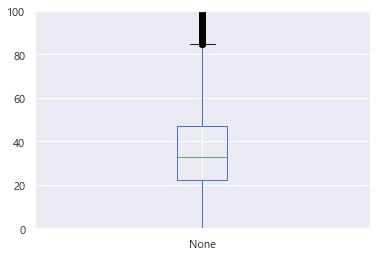

In [13]:
temp = (data['적정가격'] - data['주가']) / data['주가'] * 100
temp.plot(kind = "box", ylim = (0, 100))

In [14]:
display(temp.describe().round(3))

count    12521.000
mean        73.756
std        327.719
min       -100.000
25%         22.186
50%         32.827
75%         47.205
max       7238.741
dtype: float64

In [15]:
display(data.iloc[temp.argmax()])
display(data.iloc[temp.argmin()])

종목명                     삼성전자
리포트제목            상저하고에 대비하자.
적정가격               3800000.0
의견                        매수
증권사                    유안타증권
날짜       2018-03-22 00:00:00
주가                   51780.0
Name: 12996, dtype: object

종목명                        한전KPS
리포트제목    노무비 증가 지속, 환경 정책 강화 긍정적
적정가격                         0.0
의견                            중립
증권사                         키움증권
날짜           2016-08-01 00:00:00
주가                       70500.0
Name: 16171, dtype: object

In [16]:
data = data.loc[~data['종목명'].isin(['삼성전자', '대한해운'])]
data = data[data['적정가격'] > 0]

### 리포트에 따른 투자 시 기대 수익률 계산

In [17]:
def calc_ror_based_on_report(report_data, D):
    cur_sp_list = report_data['주가'].values
    fut_date_list = (report_data['날짜'] + pd.to_timedelta(D, "D")).values
    fut_sp_list = []
    for stock_name, fut_date in zip(report_data['종목명'], fut_date_list):
        fut_sp = find_stock_price(stock_name, fut_date, "future")
        fut_sp_list.append(fut_sp)
    fut_sp_list = np.array(fut_sp_list)
    ror_list = (fut_sp_list - cur_sp_list) / cur_sp_list * 100
    ror_list = ror_list[~np.isnan(ror_list)]
    return ror_list

In [18]:
buy_data = data.loc[data['의견'] == "매수"]
hold_data = data.loc[data['의견'] == "중립"]

In [19]:
buy_3M_ror_list = calc_ror_based_on_report(buy_data, 90)
hold_3M_ror_list = calc_ror_based_on_report(hold_data, 90)
buy_6M_ror_list = calc_ror_based_on_report(buy_data, 180)
hold_6M_ror_list = calc_ror_based_on_report(hold_data, 180)
buy_1Y_ror_list = calc_ror_based_on_report(buy_data, 365)
hold_1Y_ror_list = calc_ror_based_on_report(hold_data, 365)

#### 시각화

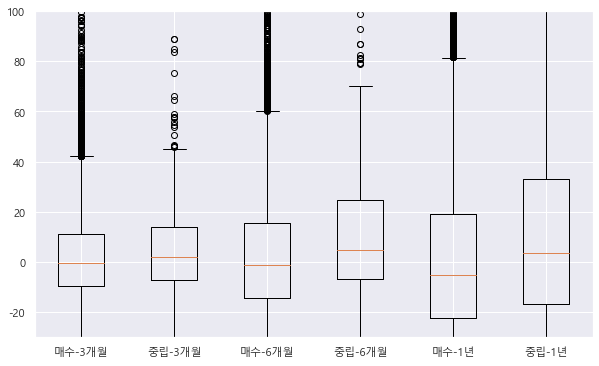

In [20]:
plt.figure(figsize = (10, 6))
plt.boxplot([buy_3M_ror_list, hold_3M_ror_list,
             buy_6M_ror_list, hold_6M_ror_list,
             buy_1Y_ror_list, hold_1Y_ror_list])
plt.ylim(-30, 100)
plt.xticks(range(1, 7), ['매수-3개월', '중립-3개월',
                         '매수-6개월', '중립-6개월',
                         '매수-1년', '중립-1년'])
plt.show()

In [21]:
result = pd.concat([pd.Series(buy_3M_ror_list).describe(),
                    pd.Series(hold_3M_ror_list).describe(),
                    pd.Series(buy_6M_ror_list).describe(),
                    pd.Series(hold_6M_ror_list).describe(),
                    pd.Series(buy_1Y_ror_list).describe(),
                    pd.Series(hold_1Y_ror_list).describe()],
                   axis = 1)

result.columns = ['매수-3개월', '중립-3개월', '매수-6개월', '중립-6개월', '매수-1년', '중립-1년']
display(result.round(2))

,매수-3개월,중립-3개월,매수-6개월,중립-6개월,매수-1년,중립-1년
count,11335.00,463.00,10606.00,426.00,9176.00,347.00
mean,2.40,5.68,3.96,11.67,5.03,14.39
std,20.49,20.19,32.26,31.83,47.95,47.31
min,-58.24,-49.20,-70.07,-46.32,-84.13,-71.04
25%,-9.62,-7.33,-14.40,-6.79,-22.36,-16.87
50%,-0.20,2.20,-1.15,4.62,-5.19,3.42
75%,11.11,13.78,15.48,24.88,19.22,32.96
max,493.24,121.54,607.00,238.42,1162.54,250.00


### 적정 가격 관련 분석

#### 적정 가격과 현재 가격의 차이 (%) 계산

In [22]:
data['적정증가율'] = (data['적정가격'] - data['주가']) / data['주가'] * 100
data = data.loc[data['적정증가율'] > 0]

In [23]:
def assign_group(inc):
    if inc >= 100:
        return "100%이상"
    elif inc >= 80:
        return "80-100%"
    elif inc >= 60:
        return "60-80%"
    elif inc>= 40:
        return "40-60%"
    elif inc>=20:
        return "20-40%"
    else:
        return "0-20%"

In [24]:
data['적정증가율_그룹'] = data['적정증가율'].apply(assign_group)
display(data['적정증가율_그룹'].value_counts())

20-40%     5374
40-60%     2664
0-20%      2022
100%이상      872
60-80%      694
80-100%     170
Name: 적정증가율_그룹, dtype: int64

#### 적정 가격 도달까지 걸리는 시간 계산

In [25]:
def cal_time_to_price(stock_name, date, price):
    stock_data = sp_data_dict[stock_name]
    cond = (stock_data['Date'] >= date) & (stock_data['Close'] >= price)
    if sum(cond) > 0:
        target_date = stock_data.loc[cond, 'Date'].iloc[0]
        return (target_date - date).days
    else:
        return np.nan

In [26]:
value_list = []
for idx, row in data.iterrows():
    value = cal_time_to_price(row["종목명"], row["날짜"], row["적정가격"])
    value_list.append(value)
data["적정가격_도달시간"] = value_list

#### 적정 가격까지 도달한 종목의 비율 확인

In [27]:
A = data["날짜"] < pd.to_datetime("2021-06-30")
B = data["적정가격_도달시간"].notnull()
print("3개월 이전: {}".format(round(sum(A&B) / sum(A),3)))

A = data["날짜"] < pd.to_datetime("2021-03-31")
B = data["적정가격_도달시간"].notnull()
print("6개월 이전: {}".format(round(sum(A&B) / sum(A),3)))

A = data["날짜"] < pd.to_datetime("2020-09-30")
B = data["적정가격_도달시간"].notnull()
print("1년 이전: {}".format(round(sum(A&B) / sum(A),3)))

3개월 이전: 0.526
6개월 이전: 0.547
1년 이전: 0.553


#### 적정 가격에 도달하기까지 소요된 시간 분포 확인

In [28]:
data.dropna(inplace = True)

In [29]:
display(data['적정가격_도달시간'].describe().astype(int))

count    5942
mean      379
std       374
min         1
25%        86
50%       238
75%       594
max      2038
Name: 적정가격_도달시간, dtype: int32

In [30]:
display(data.groupby(['적정증가율_그룹'])['적정가격_도달시간'].describe().round(2))

,count,mean,std,min,25%,50%,75%,max
적정증가율_그룹,,,,,,,,
0-20%,1439.0,216.64,293.75,1.0,28.0,84.0,277.0,1827.0
100%이상,137.0,848.36,488.62,27.0,487.0,775.0,1184.0,2038.0
20-40%,2892.0,379.74,361.23,2.0,99.0,239.0,573.5,1850.0
40-60%,1140.0,484.02,379.22,13.0,176.0,387.5,728.0,1977.0
60-80%,269.0,537.41,365.51,23.0,255.0,456.0,812.0,1874.0
80-100%,65.0,519.32,375.23,21.0,240.0,429.0,770.0,1624.0
